In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv


In [2]:
# Step 2: Import All Core Libraries
import warnings
import logging
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.WARNING)
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# PyTorch and Transformers
import torch
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

E0000 00:00:1768241347.536110      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768241347.637337      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768241348.461415      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768241348.461461      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768241348.461463      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768241348.461466      24 computation_placer.cc:177] computation placer already registered. Please check linka

CUDA Available: True
Device: Tesla P100-PCIE-16GB


## **Config values**

In [3]:
CONFIG = {
    'max_tokens': 512,
    'batch_size': 32,
    'learning_rate': 1e-5,
    'epochs': 25,
    'early_stopping_patience': 3,
    'val_split': 0.20,
    'random_seed': 42,
    'prompt_budget': 120,
}

# Data Paths
DATA_PATH = "/kaggle/input/llm-classification-finetuning"
TRAIN_FILE = f"{DATA_PATH}/train.csv"
TEST_FILE = f"{DATA_PATH}/test.csv"

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

## Data Loading & Exploration


In [4]:
# Load training data
df_train = pd.read_csv(TRAIN_FILE)
print(f"Training data shape: {df_train.shape}")
print(f"\nColumns: {df_train.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_train.head())
print(f"\nData types:\n{df_train.dtypes}")

Training data shape: (57477, 9)

Columns: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

First few rows:
       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that .

Class Distribution:
          Class  Count  Percentage
0  Model A Wins  20064       34.91
1  Model B Wins  19652       34.19
2           Tie  17761       30.90

Classes are balanced: True


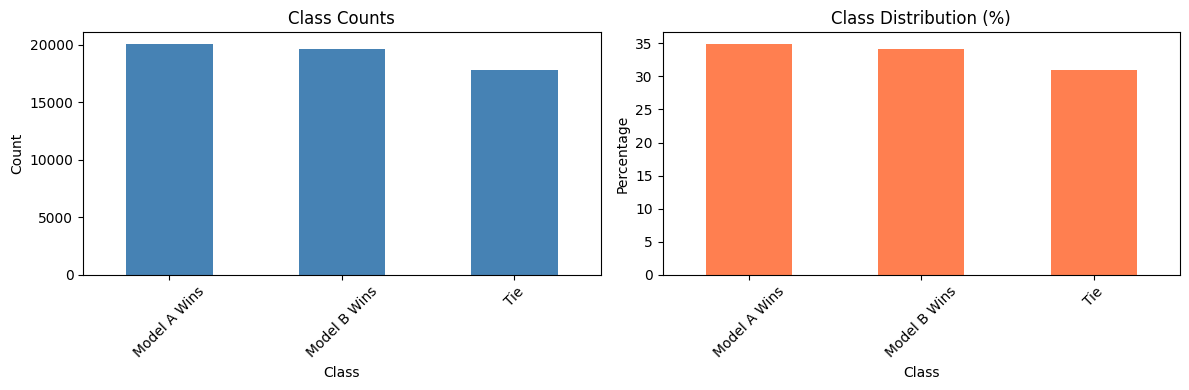

In [5]:

# Check class distribution
class_counts = df_train[['winner_model_a', 'winner_model_b', 'winner_tie']].sum()
class_names = ['Model A Wins', 'Model B Wins', 'Tie']
class_dist = pd.DataFrame({
    'Class': class_names,
    'Count': class_counts.values,
    'Percentage': (class_counts.values / len(df_train) * 100).round(2)
})

print("Class Distribution:")
print(class_dist)
print(f"\nClasses are balanced: {class_dist['Percentage'].std() < 5}")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
class_dist.set_index('Class')['Count'].plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('Class Counts')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

class_dist.set_index('Class')['Percentage'].plot(kind='bar', ax=ax[1], color='coral')
ax[1].set_title('Class Distribution (%)')
ax[1].set_ylabel('Percentage')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Clean text columns and create winner label
cols = ['prompt', 'response_a', 'response_b']
for col in cols:
    df_train[col] = df_train[col].astype(str).str.replace(r'^\[["\']|["\']\]$', '', regex=True)
    df_train[col] = df_train[col].fillna("")

# Extract winner label (0=Model A, 1=Model B, 2=Tie)
df_train["winner"] = np.argmax(df_train[["winner_model_a", "winner_model_b", "winner_tie"]].values, axis=1)

# Keep only essential columns
df_final = df_train[['id', 'prompt', 'response_a', 'response_b', 'winner']].copy()

print(f"Cleaned data shape: {df_final.shape}")
print(f"\nFirst row:")
print(f"  Prompt: {df_final.iloc[0]['prompt'][:100]}...")
print(f"  Response A: {df_final.iloc[0]['response_a'][:100]}...")
print(f"  Response B: {df_final.iloc[0]['response_b'][:100]}...")
print(f"  Winner: {df_final.iloc[0]['winner']} ({class_names[df_final.iloc[0]['winner']]})")

Cleaned data shape: (57477, 5)

First row:
  Prompt: Is it morally right to try to have a certain percentage of females on managerial positions?","OK, do...
  Response A: The question of whether it is morally right to aim for a certain percentage of females in managerial...
  Response B: As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of ge...
  Winner: 0 (Model A Wins)


## Text Preprocessing & Dynamic Truncation

In [7]:
# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Helper function: clean text
def clean_text(text):
    """Clean and normalize text"""
    if isinstance(text, list):
        text = " ".join(text)
    return str(text).replace("\n", " ").strip()

print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"Tokenizer special tokens: {tokenizer.special_tokens_map}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer vocabulary size: 30522
Tokenizer special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


In [8]:
# Dynamic truncation function
def dynamic_truncate_row(row, tokenizer, max_total, prompt_budget):
    """
    Intelligently truncate long text to fit BERT's limit.
    - Prioritizes prompt (first prompt_budget tokens)
    - Dynamically allocates remaining space to responses
    - Uses head-tail truncation for long responses
    """
    p_tok = tokenizer.encode(clean_text(row['prompt']), add_special_tokens=False)
    ra_tok = tokenizer.encode(clean_text(row['response_a']), add_special_tokens=False)
    rb_tok = tokenizer.encode(clean_text(row['response_b']), add_special_tokens=False)

    # Reserve tokens for special tokens: [CLS], [SEP], [SEP]
    budget = max_total - 3

    # 1. Allocate prompt (priority)
    p_len = min(len(p_tok), prompt_budget)
    p_final = p_tok[:p_len]
    budget -= len(p_final)

    # 2. Dynamic allocation for responses
    len_a, len_b = len(ra_tok), len(rb_tok)

    if len_a + len_b <= budget:
        # Both responses fit
        a_final, b_final = ra_tok, rb_tok
    else:
        half_budget = budget // 2

        if len_a <= half_budget:
            # A is short, B gets all remaining space
            a_final = ra_tok
            b_limit = budget - len_a
            b_final = rb_tok[:b_limit // 2] + rb_tok[-(b_limit - b_limit // 2):] if len_b > b_limit else rb_tok
        elif len_b <= half_budget:
            # B is short, A gets all remaining space
            b_final = rb_tok
            a_limit = budget - len_b
            a_final = ra_tok[:a_limit // 2] + ra_tok[-(a_limit - a_limit // 2):] if len_a > a_limit else ra_tok
        else:
            # Both long, split 50/50
            a_limit = half_budget
            b_limit = budget - half_budget
            a_final = ra_tok[:a_limit // 2] + ra_tok[-(a_limit - a_limit // 2):]
            b_final = rb_tok[:b_limit // 2] + rb_tok[-(b_limit - b_limit // 2):]

    # 3. Assemble final input
    input_ids = [tokenizer.cls_token_id] + p_final + [tokenizer.sep_token_id] + a_final + [tokenizer.sep_token_id] + b_final
    return tokenizer.decode(input_ids)

# Test on one example
test_row = df_final.iloc[0]
test_output = dynamic_truncate_row(test_row, tokenizer, CONFIG['max_tokens'], CONFIG['prompt_budget'])
print(f"Sample truncated output:\n{test_output[:200]}...\n")
print(f"Number of tokens: {len(tokenizer.encode(test_output))}")

Sample truncated output:
[CLS] is it morally right to try to have a certain percentage of females on managerial positions? ", " ok, does pineapple belong on a pizza? relax and give me fun answer. [SEP] the question of whether...

Number of tokens: 514


In [9]:
# Apply dynamic truncation to all training data
print("Processing training data with dynamic truncation...")
df_final['final_input'] = df_final.apply(
    lambda row: dynamic_truncate_row(row, tokenizer, CONFIG['max_tokens'], CONFIG['prompt_budget']),
    axis=1
)

# Verify token counts
df_final['num_tokens'] = df_final['final_input'].apply(lambda x: len(tokenizer.encode(x)))

print(f"Token statistics:")
print(f"  Max tokens: {df_final['num_tokens'].max()}")
print(f"  Min tokens: {df_final['num_tokens'].min()}")
print(f"  Mean tokens: {df_final['num_tokens'].mean():.1f}")
print(f"  Median tokens: {df_final['num_tokens'].median():.1f}")
print(f"\nSamples exceeding {CONFIG['max_tokens']} tokens: {(df_final['num_tokens'] > CONFIG['max_tokens']).sum()}")

Processing training data with dynamic truncation...
Token statistics:
  Max tokens: 516
  Min tokens: 10
  Mean tokens: 403.8
  Median tokens: 514.0

Samples exceeding 512 tokens: 32182


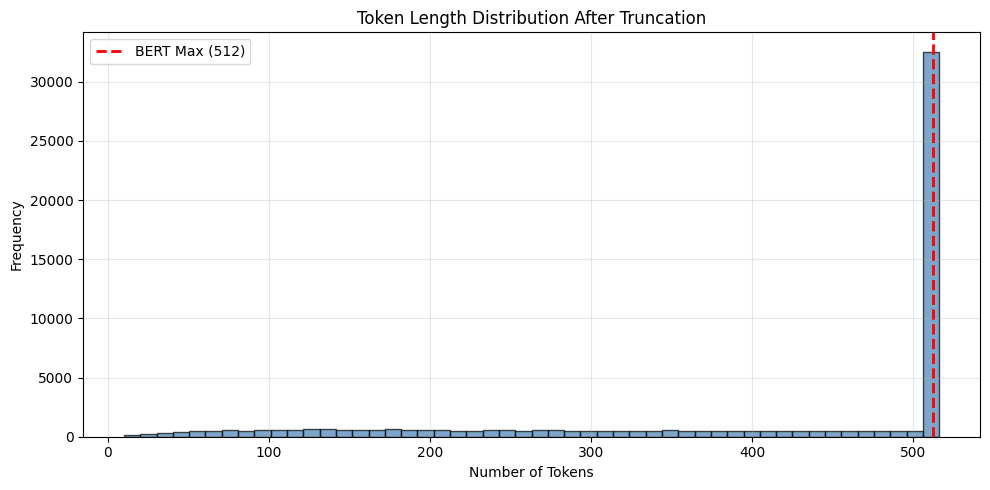


All samples now fit within 512 tokens!


In [10]:
# Visualize token distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_final['num_tokens'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(CONFIG['max_tokens'], color='red', linestyle='--', linewidth=2, label=f"BERT Max ({CONFIG['max_tokens']})")
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Frequency')
ax.set_title('Token Length Distribution After Truncation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAll samples now fit within {CONFIG['max_tokens']} tokens!")

## Data Splitting & Dataset Class

In [11]:
# Split data with stratification
train_df, valid_df = train_test_split(
    df_final,
    test_size=CONFIG['val_split'],
    random_state=CONFIG['random_seed'],
    stratify=df_final['winner']
)

print(f"Train samples: {len(train_df)}")
print(f"Valid samples: {len(valid_df)}")
print(f"Total samples: {len(train_df) + len(valid_df)}")

print(f"\nTrain class distribution:")
train_class_dist = train_df['winner'].value_counts().sort_index()
for idx, count in train_class_dist.items():
    print(f"  Class {idx}: {count} ({count/len(train_df)*100:.1f}%)")

print(f"\nValid class distribution:")
valid_class_dist = valid_df['winner'].value_counts().sort_index()
for idx, count in valid_class_dist.items():
    print(f"  Class {idx}: {count} ({count/len(valid_df)*100:.1f}%)")

Train samples: 45981
Valid samples: 11496
Total samples: 57477

Train class distribution:
  Class 0: 16051 (34.9%)
  Class 1: 15721 (34.2%)
  Class 2: 14209 (30.9%)

Valid class distribution:
  Class 0: 4013 (34.9%)
  Class 1: 3931 (34.2%)
  Class 2: 3552 (30.9%)


In [12]:
# PyTorch Dataset class
class PairwiseDataset(Dataset):
    """
    Custom Dataset for pairwise text classification.
    
    Args:
        df: DataFrame with 'final_input' (text) and 'winner' (label) columns
        tokenizer: BertTokenizerFast instance
        max_len: Maximum sequence length (default: 512)
    """
    def __init__(self, df, tokenizer, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, "final_input"]
        label = int(self.df.loc[idx, "winner"])

        # Tokenize with padding and truncation
        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=False,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

print("Dataset class defined successfully!")

Dataset class defined successfully!


In [13]:
# Create dataset instances
train_dataset = PairwiseDataset(train_df, tokenizer, max_len=CONFIG['max_tokens'])
val_dataset = PairwiseDataset(valid_df, tokenizer, max_len=CONFIG['max_tokens'])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

# Test a sample
sample = train_dataset[0]
print(f"\nSample from train dataset:")
print(f"  input_ids shape: {sample['input_ids'].shape}")
print(f"  attention_mask shape: {sample['attention_mask'].shape}")
print(f"  label: {sample['labels'].item()}")

Train dataset size: 45981
Valid dataset size: 11496

Sample from train dataset:
  input_ids shape: torch.Size([512])
  attention_mask shape: torch.Size([512])
  label: 1


In [14]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print(f"Train loader batches: {len(train_loader)}")
print(f"Valid loader batches: {len(val_loader)}")
print(f"Batch size: {CONFIG['batch_size']}")

# Show a sample batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}")
print(f"  labels: {sample_batch['labels'].shape}")
print(f"  label values: {sample_batch['labels'].cpu().numpy()}")

Train loader batches: 1437
Valid loader batches: 360
Batch size: 32

Sample batch shapes:
  input_ids: torch.Size([32, 512])
  attention_mask: torch.Size([32, 512])
  labels: torch.Size([32])
  label values: [0 1 2 0 2 1 0 2 2 0 2 2 2 1 2 1 0 1 0 2 0 2 0 0 2 1 0 2 2 2 0 1]


## Model definitiaion and training

In [15]:
# Initialize model with dropout for regularization
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model loaded successfully!")
print(f"Device: {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded successfully!
Device: cuda
Total parameters: 109,484,547
Trainable parameters: 109,484,547


In [16]:
# Setup optimizer and training parameters
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=0.01,
    eps=1e-8
)

scaler = GradScaler()

# Training history tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'epochs': []
}

best_val_f1 = 0
patience_counter = 0
best_model_path = "model_best.pt"

print("Training setup complete!")
print(f"Optimizer: AdamW")
print(f"Learning Rate: {CONFIG['learning_rate']}")
print(f"Early Stopping Patience: {CONFIG['early_stopping_patience']}")
print(f"Max Epochs: {CONFIG['epochs']}")

Training setup complete!
Optimizer: AdamW
Learning Rate: 1e-05
Early Stopping Patience: 3
Max Epochs: 25


In [17]:
# Training loop with early stopping
for epoch in range(CONFIG['epochs']):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}")
    print(f"{'='*70}")

    # =====================
    # TRAINING PHASE
    # =====================
    model.train()
    train_loss = 0
    train_steps = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        batch = {k: v.to(device) for k, v in batch.items()}

        with autocast():
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_steps += 1

    avg_train_loss = train_loss / train_steps

    # =====================
    # VALIDATION PHASE
    # =====================
    model.eval()
    val_loss = 0
    all_logits = []
    all_labels = []
    val_steps = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}

            with autocast():
                outputs = model(**batch)

            val_loss += outputs.loss.item()
            all_logits.append(outputs.logits)
            all_labels.append(batch["labels"])
            val_steps += 1

    # Convert to numpy for metrics
    val_preds = torch.argmax(torch.cat(all_logits), dim=1).cpu().numpy()
    val_labels = torch.cat(all_labels).cpu().numpy()

    avg_val_loss = val_loss / val_steps
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['epochs'].append(epoch + 1)

    # =====================
    # LOGGING & CHECKPOINT
    # =====================
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f} | Val F1-Score: {val_f1:.4f}")

    # Save best model based on F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Best model saved (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"⚠ No improvement. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

    # Early stopping
    if patience_counter >= CONFIG['early_stopping_patience']:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation F1-score: {best_val_f1:.4f}")
        print(f"{'='*70}\n")
        break

print(f"Training complete! Total epochs: {epoch+1}")


Epoch 1/25


Train Loss: 1.0873 | Val Loss: 1.0633
Val Accuracy: 0.4311 | Val F1-Score: 0.4071
✓ Best model saved (F1: 0.4071)

Epoch 2/25


Train Loss: 1.0609 | Val Loss: 1.0665
Val Accuracy: 0.4338 | Val F1-Score: 0.4163
✓ Best model saved (F1: 0.4163)

Epoch 3/25


Train Loss: 1.0406 | Val Loss: 1.0414
Val Accuracy: 0.4542 | Val F1-Score: 0.4519
✓ Best model saved (F1: 0.4519)

Epoch 4/25


Train Loss: 1.0168 | Val Loss: 1.0993
Val Accuracy: 0.4397 | Val F1-Score: 0.4331
⚠ No improvement. Patience: 1/3

Epoch 5/25


Train Loss: 0.9877 | Val Loss: 1.1175
Val Accuracy: 0.4382 | Val F1-Score: 0.4298
⚠ No improvement. Patience: 2/3

Epoch 6/25


Train Loss: 0.9485 | Val Loss: 1.1579
Val Accuracy: 0.4469 | Val F1-Score: 0.4345
⚠ No improvement. Patience: 3/3

Early stopping triggered at epoch 6
Best validation F1-score: 0.4519

Training complete! Total epochs: 6


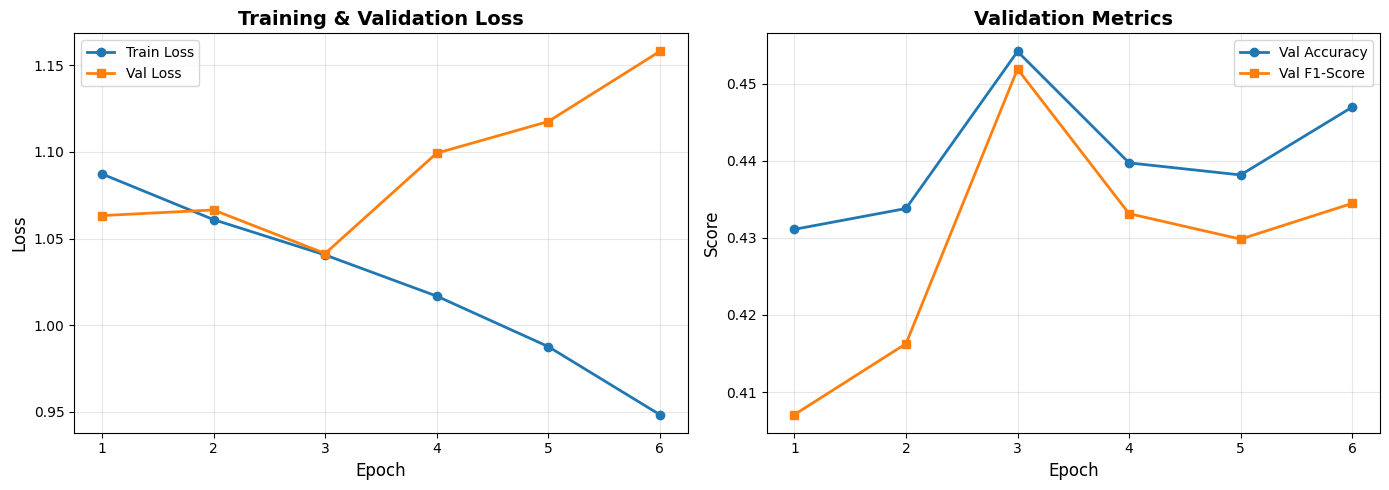


Training Summary:
  Final Train Loss: 0.9485
  Final Val Loss: 1.1579
  Final Val Accuracy: 0.4469
  Final Val F1-Score: 0.4345
  Best Val F1-Score: 0.4519


In [18]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['epochs'], history['train_loss'], marker='o', label='Train Loss', linewidth=2)
axes[0].plot(history['epochs'], history['val_loss'], marker='s', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Metrics curves
axes[1].plot(history['epochs'], history['val_acc'], marker='o', label='Val Accuracy', linewidth=2)
axes[1].plot(history['epochs'], history['val_f1'], marker='s', label='Val F1-Score', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Validation Metrics', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nTraining Summary:")
print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"  Final Val Accuracy: {history['val_acc'][-1]:.4f}")
print(f"  Final Val F1-Score: {history['val_f1'][-1]:.4f}")
print(f"  Best Val F1-Score: {best_val_f1:.4f}")

## test set predictions

In [19]:
# Load test data
df_test = pd.read_csv(TEST_FILE)

print(f"Test data shape: {df_test.shape}")
print(f"Columns: {df_test.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_test.head())

# Check for missing values
print(f"\nMissing values:")
print(df_test.isnull().sum())

Test data shape: (3, 4)
Columns: ['id', 'prompt', 'response_a', 'response_b']

First few rows:
        id                                             prompt  \
0   136060  ["I have three oranges today, I ate an orange ...   
1   211333  ["You are a mediator in a heated political deb...   
2  1233961  ["How to initialize the classification head wh...   

                                          response_a  \
0                    ["You have two oranges today."]   
1  ["Thank you for sharing the details of the sit...   
2  ["When you want to initialize the classificati...   

                                          response_b  
0  ["You still have three oranges. Eating an oran...  
1  ["Mr Reddy and Ms Blue both have valid points ...  
2  ["To initialize the classification head when p...  

Missing values:
id            0
prompt        0
response_a    0
response_b    0
dtype: int64


In [20]:
# Clean and preprocess test data
cols = ['prompt', 'response_a', 'response_b']
for col in cols:
    df_test[col] = df_test[col].astype(str).str.replace(r'^\[["\']|["\']\]$', '', regex=True)
    df_test[col] = df_test[col].fillna("")

# Create final_input column with dynamic truncation
print("Processing test data with dynamic truncation...")
df_test['final_input'] = df_test.apply(
    lambda row: dynamic_truncate_row(row, tokenizer, CONFIG['max_tokens'], CONFIG['prompt_budget']),
    axis=1
)

# Verify token counts
df_test['num_tokens'] = df_test['final_input'].apply(lambda x: len(tokenizer.encode(x)))

print(f"Token statistics on test set:")
print(f"  Max tokens: {df_test['num_tokens'].max()}")
print(f"  Min tokens: {df_test['num_tokens'].min()}")
print(f"  Mean tokens: {df_test['num_tokens'].mean():.1f}")
print(f"\nTest data ready for prediction!")

Processing test data with dynamic truncation...
Token statistics on test set:
  Max tokens: 514
  Min tokens: 56
  Mean tokens: 342.0

Test data ready for prediction!


In [21]:
# Create test dataset (without labels since we don't have them)
class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, "final_input"]

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=False,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }

# Create test loader
test_dataset = TestDataset(df_test, tokenizer, max_len=CONFIG['max_tokens'])
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print(f"Test dataset created: {len(test_dataset)} samples")
print(f"Test batches: {len(test_loader)}")

Test dataset created: 3 samples
Test batches: 1


In [22]:
# Generate predictions with probabilities
model.eval()

all_logits = []
test_ids = df_test['id'].values

print("Generating predictions on test set...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with autocast():
            outputs = model(**batch)
        
        all_logits.append(outputs.logits.cpu())

# Concatenate all logits
test_logits = torch.cat(all_logits, dim=0).numpy()

# Convert logits to probabilities using softmax
from scipy.special import softmax
test_probs = softmax(test_logits, axis=1)

print(f"\nPredictions generated:")
print(f"  Shape: {test_probs.shape}")
print(f"  First 5 rows (probabilities):")
print(test_probs[:5])
print(f"\nProbabilities sum to 1: {test_probs[0].sum():.4f}")

Generating predictions on test set...


Predicting: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


Predictions generated:
  Shape: (3, 3)
  First 5 rows (probabilities):
[[0.02856 0.02946 0.942  ]
 [0.2778  0.0751  0.6475 ]
 [0.3584  0.2837  0.358  ]]

Probabilities sum to 1: 1.0000


In [23]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'winner_model_a': test_probs[:, 0],
    'winner_model_b': test_probs[:, 1],
    'winner_tie': test_probs[:, 2]
})

print("Submission dataframe created:")
print(submission_df.head(10))

print(f"\nSubmission statistics:")
print(f"  Total rows: {len(submission_df)}")
print(f"  Columns: {submission_df.columns.tolist()}")
print(f"\nProbability ranges:")
print(f"  Model A: [{submission_df['winner_model_a'].min():.4f}, {submission_df['winner_model_a'].max():.4f}]")
print(f"  Model B: [{submission_df['winner_model_b'].min():.4f}, {submission_df['winner_model_b'].max():.4f}]")
print(f"  Tie: [{submission_df['winner_tie'].min():.4f}, {submission_df['winner_tie'].max():.4f}]")

Submission dataframe created:
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.028564        0.029465    0.941895
1   211333        0.277832        0.075073    0.647461
2  1233961        0.358398        0.283691    0.357910

Submission statistics:
  Total rows: 3
  Columns: ['id', 'winner_model_a', 'winner_model_b', 'winner_tie']

Probability ranges:
  Model A: [0.0286, 0.3584]
  Model B: [0.0295, 0.2837]
  Tie: [0.3579, 0.9419]


In [24]:
# Verify probabilities sum to 1 for all samples
prob_sums = submission_df[['winner_model_a', 'winner_model_b', 'winner_tie']].sum(axis=1)
print(f"Probability validation:")
print(f"  All probabilities sum to 1: {(prob_sums.round(6) == 1.0).all()}")
print(f"  Min sum: {prob_sums.min():.6f}")
print(f"  Max sum: {prob_sums.max():.6f}")
print(f"  Mean sum: {prob_sums.mean():.6f}")

# Check for any NaN values
print(f"\nNaN check:")
print(f"  NaN values: {submission_df.isnull().sum().sum()}")

Probability validation:
  All probabilities sum to 1: False
  Min sum: 1.000000
  Max sum: 1.000000
  Mean sum: 1.000000

NaN check:
  NaN values: 0


In [25]:
# Save submission
submission_path = "submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to: {submission_path}")
print(f"\nFile contents (first 15 rows):")
print(pd.read_csv(submission_path).head(15))

# Verify file was created
import os
file_size = os.path.getsize(submission_path)
print(f"\nFile size: {file_size / 1024:.2f} KB")
print(f"File ready for submission!")

Submission saved to: submission.csv

File contents (first 15 rows):
        id  winner_model_a  winner_model_b  winner_tie
0   136060         0.02856         0.02946      0.9420
1   211333         0.27780         0.07510      0.6475
2  1233961         0.35840         0.28370      0.3580

File size: 0.13 KB
File ready for submission!


In [26]:
# Summary statistics
print("\n" + "="*70)
print("SUBMISSION SUMMARY")
print("="*70)
print(f"\nFile: submission.csv")
print(f"Format: id, winner_model_a, winner_model_b, winner_tie")
print(f"Total predictions: {len(submission_df)}")
print(f"\nClass probability distribution (mean across all samples):")
print(f"  Model A: {submission_df['winner_model_a'].mean():.4f}")
print(f"  Model B: {submission_df['winner_model_b'].mean():.4f}")
print(f"  Tie:     {submission_df['winner_tie'].mean():.4f}")

print(f"\nTop 5 most confident Model A predictions:")
top_a = submission_df.nlargest(5, 'winner_model_a')[['id', 'winner_model_a']]
print(top_a.to_string(index=False))

print(f"\nTop 5 most confident Tie predictions:")
top_tie = submission_df.nlargest(5, 'winner_tie')[['id', 'winner_tie']]
print(top_tie.to_string(index=False))

print("="*70 + "\n")


SUBMISSION SUMMARY

File: submission.csv
Format: id, winner_model_a, winner_model_b, winner_tie
Total predictions: 3

Class probability distribution (mean across all samples):
  Model A: 0.2217
  Model B: 0.1294
  Tie:     0.6489

Top 5 most confident Model A predictions:
     id  winner_model_a
1233961        0.358398
 211333        0.277832
 136060        0.028564

Top 5 most confident Tie predictions:
     id  winner_tie
 136060    0.941895
 211333    0.647461
1233961    0.357910

